In [15]:
from torchvision import transforms 

from data_utils import (mean, std, load_dataset, load_batch, getting_total_batch_sizes,
                       getting_classes_names, create_dict_dataloaders, iterate_dataloader)
from training_utils import train_model, evaluate_model, show_predictions, imshow

In [16]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
    ])

In [17]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [18]:
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
# id 975-980
train_dir = '../datasets/Spill_Data/Train'
test_dir = '../datasets/Spill_Data/Test'
batch_size = 8
num_workers = 4

In [19]:
train_data = load_dataset(root=train_dir, transform=train_transform)


In [20]:
train_data

Dataset ImageFolder
    Number of datapoints: 300
    Root location: ../datasets/Spill_Data/Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [21]:
train_loader = load_batch(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [22]:
test_data = load_dataset(root=test_dir, transform=test_transform)

In [23]:
test_data

Dataset ImageFolder
    Number of datapoints: 112
    Root location: ../datasets/Spill_Data/Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [24]:
test_loader = load_batch(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [25]:
class_names = getting_classes_names(train_data)
print(class_names)
total_batch_sizes = getting_total_batch_sizes(train_loader, test_loader)
print(total_batch_sizes)
dataloaders = create_dict_dataloaders(train_loader, test_loader)

['NoSpill', 'OilSpill']
{'train': 38, 'test': 14}


In [26]:
total_batch_sizes

{'train': 38, 'test': 14}

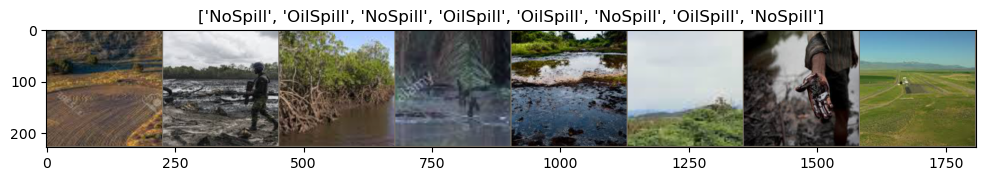

In [27]:
inputs, classes = iterate_dataloader(dataloaders['train'])
imshow(inputs, title=[class_names[x] for x in classes])

## Load ResNet18 model

In [21]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import models

In [22]:
model = models.resnet18(pretrained=True) 

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [25]:
# calculate the top number of layers that the model has
count = 0 
for child in model.children():
    count+=1
    
count

10

In [27]:
# Freeze the first 6 layers of the model, to mitigate overfitting and because they extract more generic features
count = 0 
for child in model.children():
    count+=1
    if count < 7:
        for param in child.parameters():
            param.requires_grad = False

In [28]:
# replace the last layer 

model.fc = nn.Linear(num_ftrs, 2)

In [29]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
criterion        = nn.CrossEntropyLoss()

optimizer_ft     = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, 
                    total_batch_sizes, batch_size, num_epochs=5)

In [32]:
#model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


C:\Users\platon\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 4.1554 Acc: 0.8158
test Loss: 0.7406 Acc: 0.9643
Epoch 1/4
----------
train Loss: 2.5389 Acc: 0.8651
test Loss: 1.4691 Acc: 0.8839
Epoch 2/4
----------
train Loss: 1.4766 Acc: 0.9178
test Loss: 0.6609 Acc: 0.9732
Epoch 3/4
----------
train Loss: 1.4982 Acc: 0.9145
test Loss: 0.6275 Acc: 0.9732
Epoch 4/4
----------
train Loss: 2.2300 Acc: 0.8980
test Loss: 1.2453 Acc: 0.9375
Training complete
Best val Acc: 0.973214


In [ ]:
evaluate_model(model, dataloaders['test'])

In [ ]:
show_predictions(model, dataloaders['test'], class_names)